In [44]:
import torch
import torch.nn as nn
from torchvision import transforms
import sys
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math


batch_size = 200
vocab_threshold = 3
vocab_from_file = True
embed_size = 256
hidden_size = 256
num_epochs = 3
save_every = 1
print_every = 100
log_file = 'training_log.txt'

transform_train = transforms.Compose([ 
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

vocab_size = len(data_loader.dataset.vocab)

encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

params = list(decoder.parameters()) + list(encoder.embed.parameters())

optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)

total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

Path /Users/user/ImageCaptioning
cocoapi/PythonAPI/annotations/captions_train2014.json
loading annotations into memory...
Done (t=0.75s)
creating index...


  0%|          | 1421/414113 [00:00<00:58, 7099.07it/s]

index created!
Obtaining caption lengths...


  9%|▊         | 36118/414113 [00:04<00:43, 8713.70it/s]

KeyboardInterrupt: 

In [2]:
import torch.utils.data as data
import numpy as np
import os

f = open(log_file, 'w')

for epoch in range(num_epochs):
    
    for i_step in range(total_step):
        
        indices = data_loader.dataset.get_train_indices()
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        images, captions = next(iter(data_loader))

        images = images.to(device)
        captions = captions.to(device)
        
        decoder.zero_grad()
        encoder.zero_grad()
        
        features = encoder(images)
        outputs = decoder(features, captions)
        
        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))        
        loss.backward()
        
        optimizer.step()
            
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))        
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        f.write(stats + '\n')
        f.flush()
        
        if i_step % print_every == 0:
            print('\r' + stats)
            
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

f.close()

torch.Size([200, 3, 224, 224])


KeyboardInterrupt: 

In [3]:
from data_loader import get_loader
from torchvision import transforms

transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])


data_loader = get_loader(transform=transform_test,    
                         mode='test')

Path /Users/user/ImageCaptioning
cocoapi/PythonAPI/annotations/captions_val2014.json
Vocabulary successfully loaded from vocab.pkl file!


In [5]:
% load_ext autoreload
% autoreload 2
import os
import torch
from model import EncoderCNN, DecoderRNN

encoder_file = "encoder-2.pkl" 
decoder_file = "decoder-2.pkl" 

embed_size = 256
hidden_size = 256

vocab_size = len(data_loader.dataset.vocab)
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, 9955) # strange diff with vocab and this number
decoder.eval()

encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file),map_location='cpu'))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file),map_location='cpu'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
from matplotlib import pyplot as plt

In [29]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

In [30]:
import cv2
def get_prediction1(imagename):
    user_image = cv2.imread(imagename)
    user_image = cv2.cvtColor(user_image, cv2.COLOR_BGR2RGB)

    plt.imshow(np.squeeze(user_image))
    plt.title('Sample Image')
    plt.show()
    
    user_image = cv2.resize(user_image, (224, 224))
    user_image = user_image[np.newaxis, ...]
    user_image = user_image.transpose((0, 3, 2, 1))
    user_image = torch.from_numpy(user_image).type('torch.FloatTensor')
    features = encoder(user_image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

In [31]:
def clean_sentence(output):
    sentense = ''
    for i in output:
        word = data_loader.dataset.vocab.idx2word[i]
        if i == 0:
            continue
        if i == 1:
            break
        if i == 18:
            sentense = sentense + word
        else:
            sentense = sentense + ' ' + word
    
    return sentense.strip()

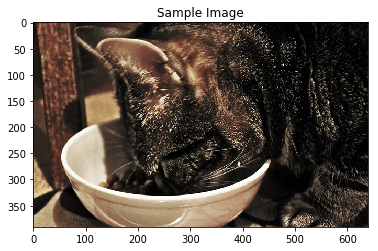

a cat sitting on a coffee next to a spice.


In [32]:
get_prediction()
# print(orig_image.size())